In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere


DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, '5000s_Loc1y2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

(5000, 176, 384)
(5000, 8)


In [3]:
from tqdm.notebook import tqdm

print(lfp[0,:,:].shape)
print(params.ELECTRODE_POSITION[:,:2].shape)

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i,:,:], params.ELECTRODE_POSITION[:, :2])#, y_window_size=960.0)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(176, 384)
(384, 2)


  0%|          | 0/5000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [4]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [5]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['y', 'd', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
[[-0.28243172 -0.54532796  0.26417643 ...  0.33010416 -0.40066101
   0.90986501]
 [ 0.00373346 -0.36648332 -0.11219416 ... -0.44178461  0.96102158
   0.3522956 ]
 [ 0.23562039  0.59473091 -0.17367867 ... -0.86911191 -0.52298181
  -0.95374107]
 ...
 [-0.95748326  0.36562874  0.12357903 ...  0.84211417 -0.05363294
   0.21249587]
 [ 0.14642616  0.25605996  0.30858309 ... -0.29179869 -0.47761528
   0.65440072]
 [ 0.10138561 -0.86443862  0.28912198 ... -0.71510536  0.48503193
   0.79542243]]


In [6]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(5000, 40)


In [8]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=8)

device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:03<18:33,  3.72s/it]

Training Loss: 470.32838379591703 Validation Loss: 136.0226098895073


  4%|▎         | 11/300 [00:37<15:03,  3.13s/it]

Training Loss: 336.9306833669543 Validation Loss: 116.66986994445324


  7%|▋         | 21/300 [01:08<14:12,  3.05s/it]

Training Loss: 324.2996150813997 Validation Loss: 114.93845304846764


 10%|█         | 31/300 [01:38<13:29,  3.01s/it]

Training Loss: 315.6499949991703 Validation Loss: 115.60721379891038


 14%|█▎        | 41/300 [02:10<14:41,  3.40s/it]

Training Loss: 278.9361894838512 Validation Loss: 106.82080737873912


 17%|█▋        | 51/300 [02:47<14:59,  3.61s/it]

Training Loss: 257.34386206325144 Validation Loss: 108.58461675047874


 20%|██        | 61/300 [03:23<14:25,  3.62s/it]

Training Loss: 245.76378537155688 Validation Loss: 105.78580308146775


 24%|██▎       | 71/300 [03:59<13:58,  3.66s/it]

Training Loss: 231.97222076170146 Validation Loss: 107.10405518114567


 27%|██▋       | 81/300 [04:36<13:16,  3.64s/it]

Training Loss: 221.32727100420743 Validation Loss: 107.70168718323112


 30%|███       | 91/300 [05:12<12:33,  3.61s/it]

Training Loss: 208.36947957240045 Validation Loss: 111.43001830205321


 34%|███▎      | 101/300 [05:48<11:53,  3.59s/it]

Training Loss: 200.1955453120172 Validation Loss: 111.62702898681164


 37%|███▋      | 111/300 [06:24<11:14,  3.57s/it]

Training Loss: 190.60377781279385 Validation Loss: 113.52600477263331


 40%|████      | 121/300 [06:59<10:39,  3.57s/it]

Training Loss: 183.2242902200669 Validation Loss: 115.3434446901083


 44%|████▎     | 131/300 [07:35<10:03,  3.57s/it]

Training Loss: 173.77088118344545 Validation Loss: 116.65424452722073


 47%|████▋     | 141/300 [08:11<09:28,  3.58s/it]

Training Loss: 166.9652999676764 Validation Loss: 119.03602164238691


 50%|█████     | 151/300 [08:47<08:53,  3.58s/it]

Training Loss: 159.9798311116174 Validation Loss: 122.60097462311387


 54%|█████▎    | 161/300 [09:22<08:16,  3.57s/it]

Training Loss: 154.38039286341518 Validation Loss: 127.56635637581348


 57%|█████▋    | 171/300 [09:58<07:40,  3.57s/it]

Training Loss: 148.80110878590494 Validation Loss: 126.92771909758449


 60%|██████    | 181/300 [10:34<07:04,  3.57s/it]

Training Loss: 145.2963750460185 Validation Loss: 131.43424862250686


 64%|██████▎   | 191/300 [11:10<06:29,  3.57s/it]

Training Loss: 140.27567159803584 Validation Loss: 134.51585883647203


 67%|██████▋   | 201/300 [11:45<05:52,  3.56s/it]

Training Loss: 136.92879885109141 Validation Loss: 136.4521043561399


 70%|███████   | 211/300 [12:21<05:18,  3.57s/it]

Training Loss: 133.57696367427707 Validation Loss: 137.71116210334003


 74%|███████▎  | 221/300 [12:57<04:42,  3.58s/it]

Training Loss: 130.63381693325937 Validation Loss: 141.08147950097919


 77%|███████▋  | 231/300 [13:32<04:06,  3.58s/it]

Training Loss: 128.7324417028576 Validation Loss: 144.44410720467567


 80%|████████  | 241/300 [14:08<03:30,  3.57s/it]

Training Loss: 127.03966586617753 Validation Loss: 146.37113305181265


 84%|████████▎ | 251/300 [14:44<02:55,  3.57s/it]

Training Loss: 125.5182795538567 Validation Loss: 150.2555330581963


 87%|████████▋ | 261/300 [15:19<02:19,  3.57s/it]

Training Loss: 124.37389925681055 Validation Loss: 152.064103808254


 90%|█████████ | 271/300 [15:55<01:43,  3.57s/it]

Training Loss: 124.22769818594679 Validation Loss: 151.7331781461835


 94%|█████████▎| 281/300 [16:31<01:07,  3.57s/it]

Training Loss: 123.01238621491939 Validation Loss: 152.57185344398022


 97%|█████████▋| 291/300 [17:07<00:32,  3.57s/it]

Training Loss: 123.23837504861876 Validation Loss: 154.1256284750998


100%|██████████| 300/300 [17:39<00:00,  3.53s/it]


In [9]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.1759261479896643
(128, 8)
(128, 8)


In [10]:
if normalize_labels:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out

<IPython.core.display.Javascript object>


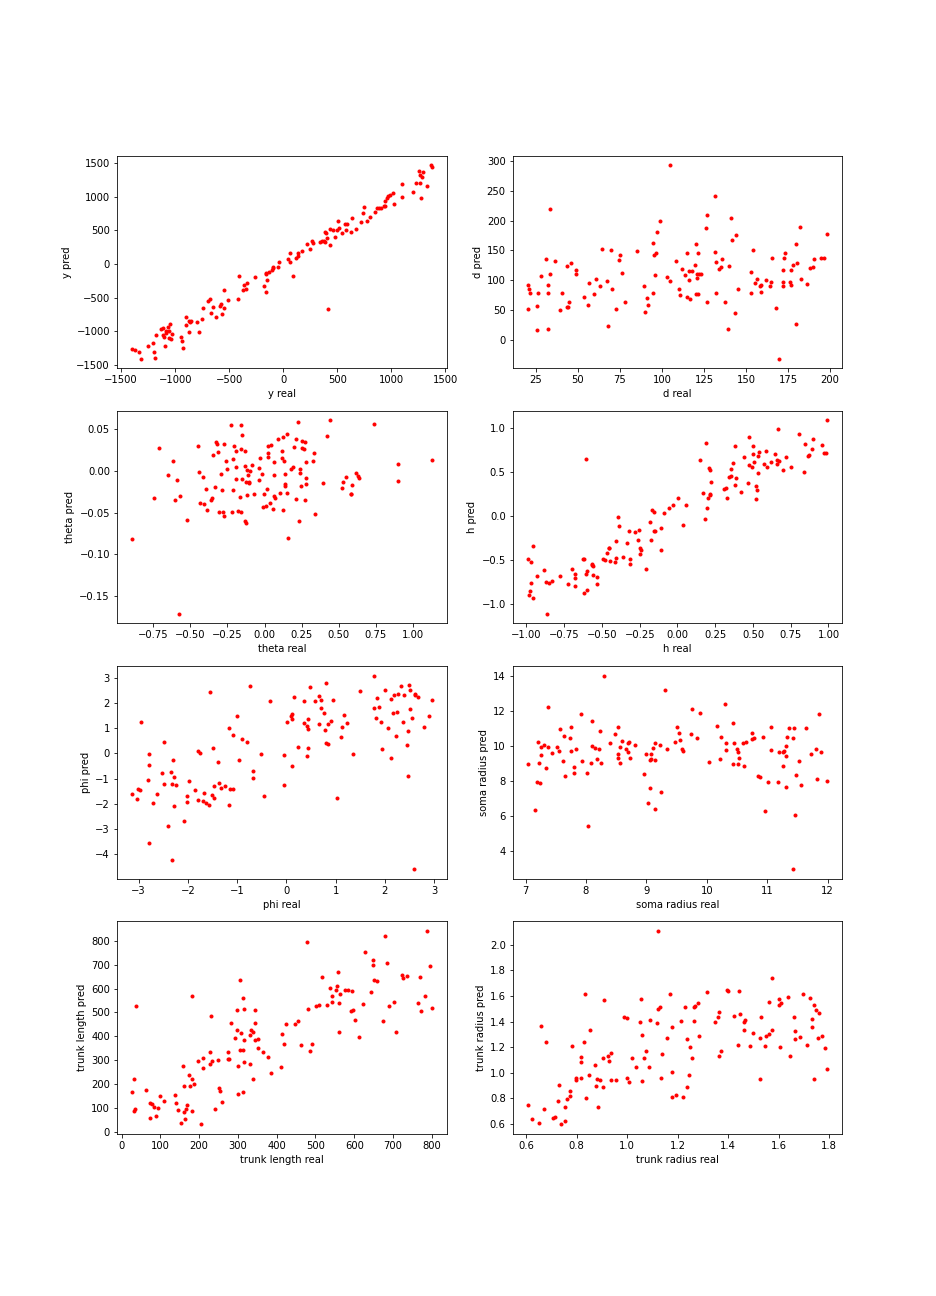

In [16]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(13, 18))

ax_y = plt.subplot(421)
ax_y.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_y.set_xlabel('y real')
ax_y.set_ylabel('y pred')

ax_d = plt.subplot(422)
ax_d.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(423)
ax_t.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(424)
ax_h.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(425)
ax_p.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(426)
ax_lt.scatter(y[:,5], output[:,5], c='red', marker='.')
ax_lt.set_xlabel('soma radius real')
ax_lt.set_ylabel('soma radius pred')

ax_lt = plt.subplot(427)
ax_lt.scatter(y[:,6], output[:,6], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')

ax_lt = plt.subplot(428)
ax_lt.scatter(y[:,7], output[:,7], c='red', marker='.')
ax_lt.set_xlabel('trunk radius real')
ax_lt.set_ylabel('trunk radius pred')


plt.show()

In [12]:
from cell_inference.utils.feature_extractors.SummaryStats2D import get_y_window

DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'all_cell_LFP_2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    c = f['coord'][:]
    d = f['data'][:]

test_data = []
summ_stats = []

print(lfp.shape)

for i in tqdm(range(d.shape[2])):
    g_lfp, g_coords = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)#, y_window_size=960.0)
    summ_stats.append(calculate_stats(g_lfp))
    test_data.append(g_lfp)

test_data = np.stack(test_data, axis=0)
summ_stats = np.stack(summ_stats, axis=0)

(5000, 176, 384)


  0%|          | 0/383 [00:00<?, ?it/s]

In [21]:
print(summ_stats.shape)

np.set_printoptions(suppress=True)

model1.eval()
summ_stats = torch.Tensor(summ_stats)
summ_stats_tensor = summ_stats.to(device)
pred = model1(summ_stats_tensor)
pred = np.squeeze(pred.to("cpu").detach().numpy())

print(pred.shape)

if normalize_labels:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred
        
df = pd.DataFrame(pred, columns = inference_list).sort_values(by='y')
display(df)

torch.Size([383, 40])
(383, 8)


,y,d,theta,h,phi,r_s,l_t,r_t
78,-1347.979126,112.390274,-0.020772,-0.901561,0.598945,10.947359,-4.647999,1.403484
168,-1295.033813,121.962288,0.056676,0.316140,2.014622,9.351770,808.165527,1.017173
91,-1290.249878,103.720222,0.034364,0.022584,1.964464,9.659488,598.291443,0.937050
166,-1277.406616,106.485252,0.039313,-0.108833,-0.866980,8.263655,760.442261,1.554606
43,-1274.912231,172.893707,0.000182,0.585530,-2.280718,10.687153,127.201805,1.345140
...,...,...,...,...,...,...,...,...
59,1404.428955,141.071548,-0.044146,-0.399074,-0.661425,8.257184,620.296875,0.721059
338,1416.104248,124.785622,-0.037209,0.045627,1.088358,11.627544,97.533966,1.576558
291,1490.475586,91.782822,-0.050831,0.560937,-0.321453,10.473820,88.417656,0.906436
244,1522.657715,88.000092,-0.024030,0.256512,-0.899261,9.138348,403.323578,1.538512


In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,y,d,theta,h,phi,r_s,l_t,r_t
78,-1347.979126,112.390274,-0.020772,-0.901561,0.598945,10.947359,-4.647999,1.403484
168,-1295.033813,121.962288,0.056676,0.316140,2.014622,9.351770,808.165527,1.017173
91,-1290.249878,103.720222,0.034364,0.022584,1.964464,9.659488,598.291443,0.937050
166,-1277.406616,106.485252,0.039313,-0.108833,-0.866980,8.263655,760.442261,1.554606
43,-1274.912231,172.893707,0.000182,0.585530,-2.280718,10.687153,127.201805,1.345140
239,-1272.234009,145.172058,0.033870,-0.150071,2.511863,7.558669,361.936981,1.559063
172,-1271.275269,104.737549,0.030524,-0.647510,1.894150,9.106609,662.327332,1.223901
99,-1257.878662,102.702759,-0.020377,-0.244089,-0.813272,11.073770,351.816193,1.040012
13,-1253.152832,55.750229,0.015818,0.455874,-1.346832,9.893580,510.307159,1.334078
187,-1247.694092,110.490654,0.045707,0.967447,-0.716478,9.009897,655.602966,1.068765


(190, 176)
(190,)
(176,)


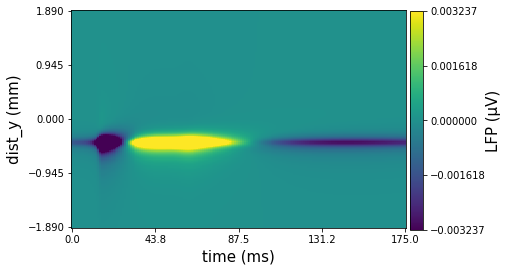

In [14]:
%matplotlib inline

cell_idx = 0

t = np.arange(test_data.shape[1])

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) & 
         (g_coords[:,1]>=ylim[0]) & 
         (g_coords[:,1]<=ylim[1]))

print(test_data[0,:,e_idx].shape)
print(g_coords[e_idx, 1].shape)
print(t.shape)

_ = plot_lfp_heatmap(t,
                     g_coords[e_idx, 1],
                     np.transpose(test_data[0,:,e_idx]), vlim='auto',
                     fontsize=15,labelpad=0,ticksize=10,nbins=5)